# Semi-Supervised Learning (part 1): Label Propagation and Label Spreading
We use Kaggle's <a href='https://www.kaggle.com/datasets/gauravtopre/bank-customer-churn-dataset'>Bank Customer Churn</a> dataset to build a **semi-supervised model for label prediction**.

We will train various models using Germany data, and predict on Spain customers to see how well the models generalize. This workbook will cover:</br>
1. **Label Propagation**, which is a graph algorithm that computes raw similarities
2. **Label Spreading**, which is similar to label propagtion, but utilizes normalization and has regularization properties making it more robust to noise.

In [1]:
import sys
import random
import datetime
from joblib import dump, load
import warnings
warnings.filterwarnings('ignore')


import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, RobustScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score, fbeta_score, precision_recall_curve, PrecisionRecallDisplay

# Import the custom NDCG class
sys.path.append('../metrics')
from NDCG_binary import NDCG


SEED = 2023
np.random.seed(SEED)
random.seed(SEED)

## 1 Load data
To recap, we are building a model using Germany's data, and see how well it generalizes to Spain.
1. Train set: 80% of Germany's data using stratified split with random shuffling</br>
2. Validation set: 20% of Germany's data using stratified split with random shuffling</br>
3. Test set: 100% of Spain's data

In [2]:
DATA_PATH = '../../data/processed'

X_train = pd.read_pickle(f'{DATA_PATH}/X_train.pkl')
X_val = pd.read_pickle(f'{DATA_PATH}/X_val.pkl')
X_test = pd.read_pickle(f'{DATA_PATH}/X_test.pkl')

for dataset in [X_train, X_val, X_test]:
    dataset.drop(columns=['country'], inplace=True)
    dataset.drop(columns=['customer_id'], inplace=True)

# Import target labels and convert them to array
y_train = pd.read_pickle(f'{DATA_PATH}/y_train.pkl').astype(int).values.ravel()
y_val = pd.read_pickle(f'{DATA_PATH}/y_val.pkl').astype(int).values.ravel()
y_test = pd.read_pickle(f'{DATA_PATH}/y_test.pkl').astype(int).values.ravel()


## 2. Data transformation
Rescale numeric features, building the transformer based on the training set (i.e. 80% of Germany's data).
* In doing so, the assumption is that the train set is representative of the validation (20% of Germany's data) and test (Spain data) sets are the same.
* Earlier, the independent t-tests and $\chi$-square tests revealed that the following features are NOT significantly different:
    * `['credit_score', 'tenure', 'products_number', 'estimated_salary', 'credit_card']`
* Ideally, we should only keep the columns that are NOT significantly different and perform the transformation.
* However, since there only a few columns, we choose to keep all of them to preseve as much information as possible

We use `RobustScaler` which is sensitive to outliers.

In [3]:
# Build the preprocessor

numeric_features_rescale = ['credit_score','age','tenure','balance','products_number','estimated_salary']
other_features = ['gender','credit_card','active_member']


# Robust scaler
trf_rescale = Pipeline(steps=[('scaler', RobustScaler())])

preprocessor = ColumnTransformer(transformers=[('num_rescale', trf_rescale, numeric_features_rescale),
                                               ('others', 'passthrough', other_features)],
                                               remainder='drop')

## 3 Modelling

### 3.1 Specify the models and the hyperparameter space

In [4]:
models = [('LabelPropagation', LabelPropagation()),
          ('LabelSpreading', LabelSpreading())
          ]

params = {
    'LabelPropagation': {
        'model__kernel': ['knn','rbf'],
        'model__gamma': np.linspace(1e-3, 1e3, num=100),
        'model__n_neighbors': list(range(3,54,3)),
    },
    'LabelSpreading': {
        'model__kernel': ['knn','rbf'],
        'model__gamma': np.linspace(1e-3, 1e3, num=100),
        'model__n_neighbors': list(range(3,54,3)),
        'model__alpha': np.linspace(1e-3, 1, num=100, endpoint=False), # Strictly between 0 and 1 (not inclusive)
    },
}

### 3.2 Specify the evaluation metrics

We will use:
1. **<a href="https://www.evidentlyai.com/ranking-metrics/ndcg-metric">Normalized Discounted Cumulative Gain (NDCG)</a>** which measures ranking quality. It compares rankings to an ideal order where all relevant items (i.e. positive labels) are at the top of the list. NDCG can take values from 0 to 1, where 1 indicates a match with the ideal order, and lower values represent a lower quality of ranking.
2. **Accuracy**
3. **F2**

In [5]:
### Custom scorer for NDCG
# Specify the top K items we want to focus on
K = 200

# Function to compute NDCG
def ndcg_custom_scorer(y_true, y_pred, k=K):
    return NDCG(y_true, y_pred, k=K).ndcg_at_k()

# Create a custom scorer
ndcg_scorer = make_scorer(ndcg_custom_scorer, greater_is_better=True, needs_proba=True, k=K)
ndcg_scorer.name = f'NDCG@{K}' # Assign a name


In [6]:
### Custom scorer for FBeta
BETA = 2

# Function to compute FBeta
def fbeta_custom_scorer(y_true, y_pred, k=K):
    return fbeta_score(y_true, y_pred, beta=BETA)


fbeta_scorer = make_scorer(fbeta_custom_scorer, greater_is_better=True)
fbeta_scorer.name = f'F{BETA}' # Assign a name

In [7]:
# Define a function to print out the key metrics and plots
def evaluate(dataset_type, optimized_on, model_name, estimator, y_true, y_pred, y_pred_proba, k):
    results = {}
    results['model'] = model_name
    results['dataset type'] = dataset_type
    results['optimized on'] = optimized_on
    results[f'NDCG@{k}'] = ndcg_custom_scorer(y_true, y_pred, k=K)
    results['accuracy'] = accuracy_score(y_true, y_pred)
    results['recall'] = recall_score(y_true, y_pred)
    results['precision'] = precision_score(y_true, y_pred)
    results['F1'] = f1_score(y_true, y_pred)
    BETA = 2
    results[f'F{BETA}'] = fbeta_score(y_true, y_pred, beta=BETA)


    # Plot subplots
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    
    # Plot Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=estimator.classes_)
    cm_display.plot(ax=ax[0])
    ax[0].set_title(f"Confusion matrix")
    
    # Plot PR Curve
    try:
        precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)
        pr_display = PrecisionRecallDisplay(precision=precision, recall=recall)
        pr_display.plot(ax=ax[1])
        ax[1].set_title(f'Precision-Recall curve')
    except ValueError as e:
        print(f"Skipping PR curve for {model_name} on {dataset_type} set due to error: {e}")
        ax[1].set_visible(False)
    
    fig.suptitle(f'{model_name} on {dataset_type} set \n optimized on {optimized_on}')
    plt.tight_layout()
    plt.show()

    return results

### 3.3 Hyperparameter tuning

In [8]:
results = []
best_estimators = []

# Train the models
for m in models:
    print('---')
    print(f'Training {m[0]} model')
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),('model', m[1])])

    optimize_metrics = {ndcg_scorer.name:ndcg_scorer, 'accuracy':'accuracy', fbeta_scorer.name:fbeta_scorer}

    for metric_name,metric in optimize_metrics.items():
        rscv = RandomizedSearchCV(pipeline, params[m[0]], cv=5, n_jobs=-1, verbose=1, scoring=metric)
        rscv.fit(X_train, y_train)

        # Save the model
        dt_ext = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        dump(rscv, f'../../logs/model_log/{m[0]}_{metric_name}_{dt_ext}.joblib')

        results.append((m[0], metric_name, pd.DataFrame(rscv.cv_results_)))
        best_estimators.append((m[0], metric_name, rscv.best_estimator_))
        print(f"best training hyperparamters (optimize on: {metric_name}): {rscv.best_params_}")


---
Training LabelPropagation model
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/sx/miniconda3/envs/uob-py3.9/lib/python3.9/site-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/Users/sx/miniconda3/envs/uob-py3.9/lib/python3.9/site-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/Users/sx/miniconda3/envs/uob-py3.9/lib/python3.9/site-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/Users/sx/miniconda3/envs/uob-py3.9/lib/python3.9/site-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/Users/sx/miniconda3/envs/uob-py3.9/lib/python3.9/site-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/Users/sx/minic

best training hyperparamters (optimize on: NDCG@200): {'model__n_neighbors': 42, 'model__kernel': 'knn', 'model__gamma': 757.576}
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/sx/miniconda3/envs/uob-py3.9/lib/python3.9/site-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/Users/sx/miniconda3/envs/uob-py3.9/lib/python3.9/site-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/Users/sx/miniconda3/envs/uob-py3.9/lib/python3.9/site-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/Users/sx/miniconda3/envs/uob-py3.9/lib/python3.9/site-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/Users/sx/miniconda3/envs/uob-py3.9/lib/python3.9/site-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/Users/sx/minic

best training hyperparamters (optimize on: accuracy): {'model__n_neighbors': 21, 'model__kernel': 'knn', 'model__gamma': 292.93}
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/sx/miniconda3/envs/uob-py3.9/lib/python3.9/site-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/Users/sx/miniconda3/envs/uob-py3.9/lib/python3.9/site-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/Users/sx/miniconda3/envs/uob-py3.9/lib/python3.9/site-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/Users/sx/miniconda3/envs/uob-py3.9/lib/python3.9/site-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/Users/sx/miniconda3/envs/uob-py3.9/lib/python3.9/site-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/Users/sx/minic

best training hyperparamters (optimize on: F2): {'model__n_neighbors': 9, 'model__kernel': 'knn', 'model__gamma': 929.293}
---
Training LabelSpreading model
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/sx/miniconda3/envs/uob-py3.9/lib/python3.9/site-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/Users/sx/miniconda3/envs/uob-py3.9/lib/python3.9/site-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/Users/sx/miniconda3/envs/uob-py3.9/lib/python3.9/site-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/Users/sx/miniconda3/envs/uob-py3.9/lib/python3.9/site-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/Users/sx/miniconda3/envs/uob-py3.9/lib/python3.9/site-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/Users/sx/minic

best training hyperparamters (optimize on: NDCG@200): {'model__n_neighbors': 24, 'model__kernel': 'knn', 'model__gamma': 919.192, 'model__alpha': 0.32068}
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/sx/miniconda3/envs/uob-py3.9/lib/python3.9/site-packages/sklearn/semi_supervised/_label_propagation.py:316: ConvergenceWarning: max_iter=30 was reached without convergence.
  warnings.warn(
/Users/sx/miniconda3/envs/uob-py3.9/lib/python3.9/site-packages/sklearn/semi_supervised/_label_propagation.py:316: ConvergenceWarning: max_iter=30 was reached without convergence.
  warnings.warn(
/Users/sx/miniconda3/envs/uob-py3.9/lib/python3.9/site-packages/sklearn/semi_supervised/_label_propagation.py:316: ConvergenceWarning: max_iter=30 was reached without convergence.
  warnings.warn(
/Users/sx/miniconda3/envs/uob-py3.9/lib/python3.9/site-packages/sklearn/semi_supervised/_label_propagation.py:316: ConvergenceWarning: max_iter=30 was reached without convergence.
  warnings.warn(
/Users/sx/miniconda3/envs/uob-py3.9/lib/python3.9/site-packages/sklearn/semi_supervised/_label_propagation.py:316: ConvergenceWarning: max_iter=30 was reached without convergence.
  warnings.warn(
/Users/sx/minic

best training hyperparamters (optimize on: accuracy): {'model__n_neighbors': 36, 'model__kernel': 'knn', 'model__gamma': 212.122, 'model__alpha': 0.35065}
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/sx/miniconda3/envs/uob-py3.9/lib/python3.9/site-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/Users/sx/miniconda3/envs/uob-py3.9/lib/python3.9/site-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/Users/sx/miniconda3/envs/uob-py3.9/lib/python3.9/site-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/Users/sx/miniconda3/envs/uob-py3.9/lib/python3.9/site-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/Users/sx/miniconda3/envs/uob-py3.9/lib/python3.9/site-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/Users/sx/minic

best training hyperparamters (optimize on: F2): {'model__n_neighbors': 12, 'model__kernel': 'knn', 'model__gamma': 131.31400000000002, 'model__alpha': 0.14086}


/Users/sx/miniconda3/envs/uob-py3.9/lib/python3.9/site-packages/sklearn/semi_supervised/_label_propagation.py:316: ConvergenceWarning: max_iter=30 was reached without convergence.
  warnings.warn(
/Users/sx/miniconda3/envs/uob-py3.9/lib/python3.9/site-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/Users/sx/miniconda3/envs/uob-py3.9/lib/python3.9/site-packages/sklearn/semi_supervised/_label_propagation.py:316: ConvergenceWarning: max_iter=30 was reached without convergence.
  warnings.warn(
/Users/sx/miniconda3/envs/uob-py3.9/lib/python3.9/site-packages/sklearn/semi_supervised/_label_propagation.py:316: ConvergenceWarning: max_iter=30 was reached without convergence.
  warnings.warn(
/Users/sx/miniconda3/envs/uob-py3.9/lib/python3.9/site-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/Users/sx/minic

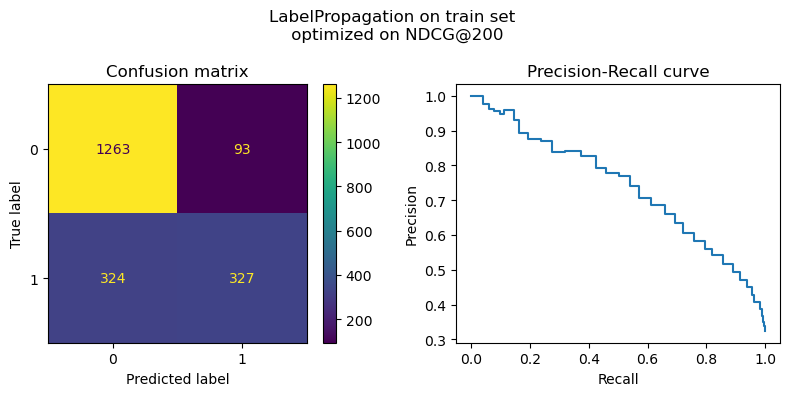

Training result (optimized on NDCG@200): {'model': 'LabelPropagation', 'dataset type': 'train', 'optimized on': 'NDCG@200', 'NDCG@200': 0.7508742453697265, 'accuracy': 0.7922272047832586, 'recall': 0.5023041474654378, 'precision': 0.7785714285714286, 'F1': 0.6106442577030813, 'F2': 0.5406746031746033}


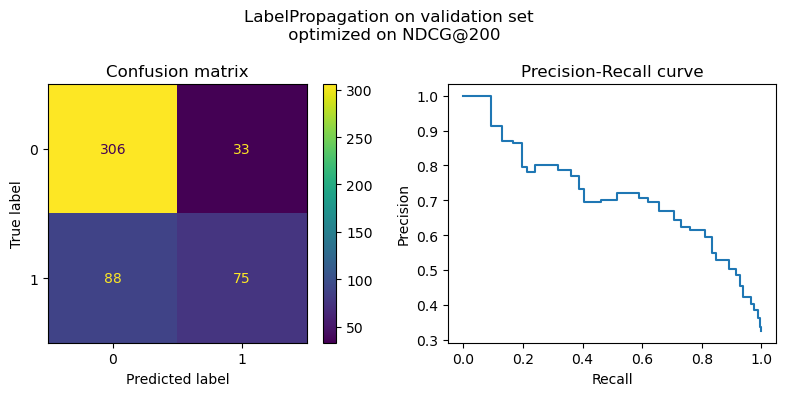

Validation result (optimized on NDCG@200): {'model': 'LabelPropagation', 'dataset type': 'validation', 'optimized on': 'NDCG@200', 'NDCG@200': 0.6129745668654301, 'accuracy': 0.7589641434262948, 'recall': 0.4601226993865031, 'precision': 0.6944444444444444, 'F1': 0.5535055350553506, 'F2': 0.493421052631579}


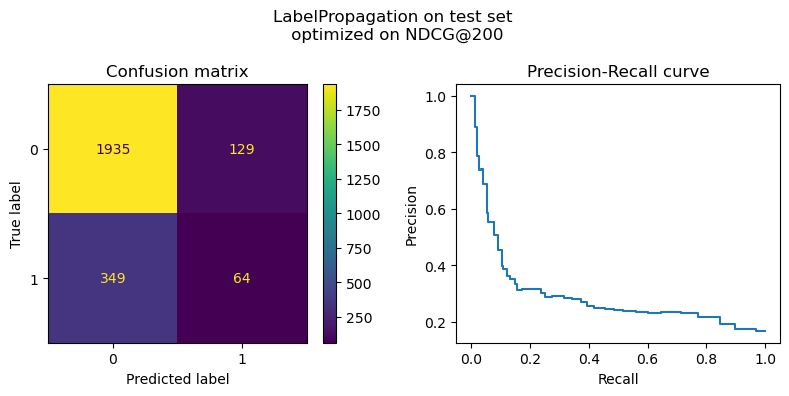

Validation result (optimized on NDCG@200): {'model': 'LabelPropagation', 'dataset type': 'test', 'optimized on': 'NDCG@200', 'NDCG@200': 0.3223310486014407, 'accuracy': 0.8070246265643924, 'recall': 0.1549636803874092, 'precision': 0.3316062176165803, 'F1': 0.21122112211221125, 'F2': 0.1734417344173442}


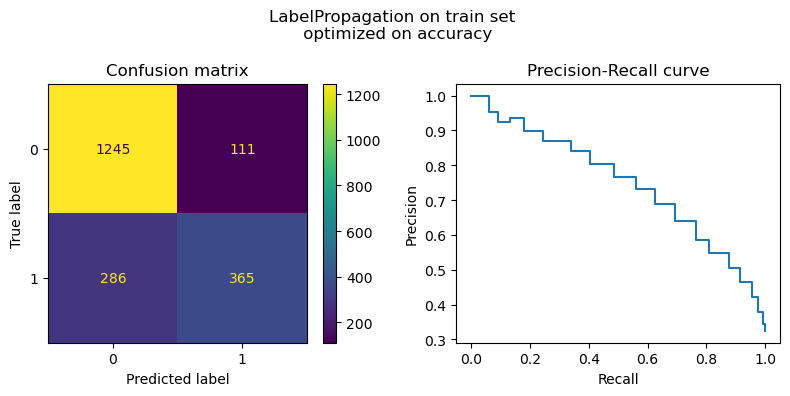

Training result (optimized on accuracy): {'model': 'LabelPropagation', 'dataset type': 'train', 'optimized on': 'accuracy', 'NDCG@200': 0.7437866898681761, 'accuracy': 0.802192326856004, 'recall': 0.5606758832565284, 'precision': 0.7668067226890757, 'F1': 0.64773735581189, 'F2': 0.5925324675324675}


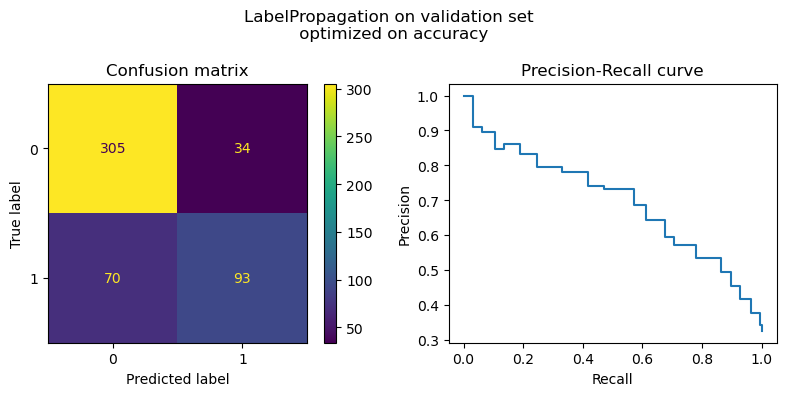

Validation result (optimized on accuracy): {'model': 'LabelPropagation', 'dataset type': 'validation', 'optimized on': 'accuracy', 'NDCG@200': 0.7039709408149959, 'accuracy': 0.7928286852589641, 'recall': 0.5705521472392638, 'precision': 0.7322834645669292, 'F1': 0.6413793103448276, 'F2': 0.5969191270860077}


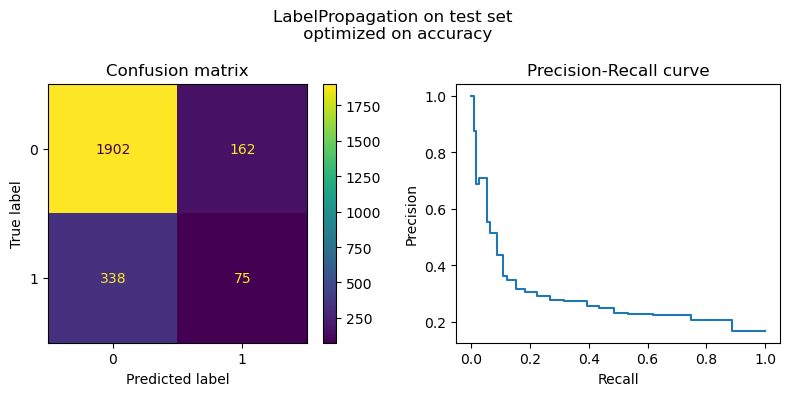

Validation result (optimized on accuracy): {'model': 'LabelPropagation', 'dataset type': 'test', 'optimized on': 'accuracy', 'NDCG@200': 0.30829803177363185, 'accuracy': 0.7981429148163101, 'recall': 0.18159806295399517, 'precision': 0.31645569620253167, 'F1': 0.23076923076923078, 'F2': 0.19851773425092642}


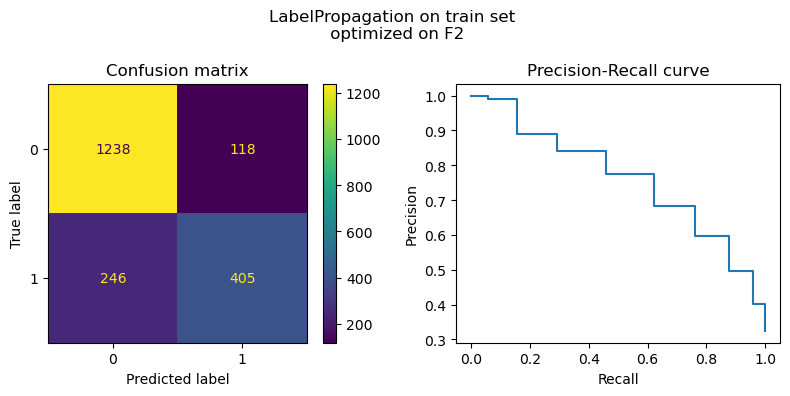

Training result (optimized on F2): {'model': 'LabelPropagation', 'dataset type': 'train', 'optimized on': 'F2', 'NDCG@200': 0.773085479507246, 'accuracy': 0.8186347782760339, 'recall': 0.6221198156682027, 'precision': 0.7743785850860421, 'F1': 0.6899488926746167, 'F2': 0.6475855452510393}


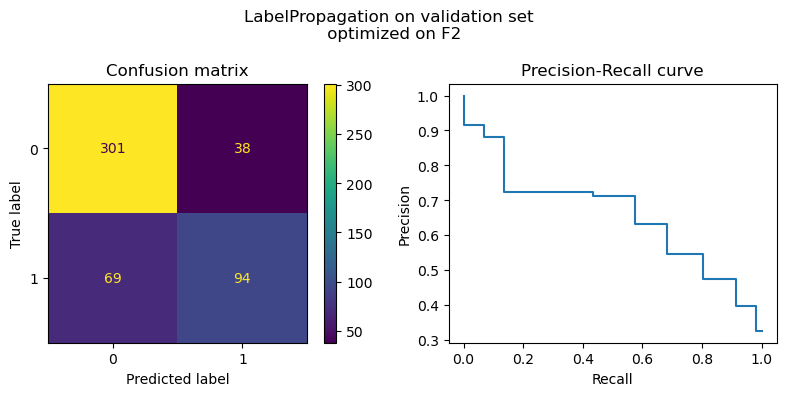

Validation result (optimized on F2): {'model': 'LabelPropagation', 'dataset type': 'validation', 'optimized on': 'F2', 'NDCG@200': 0.6852480266918759, 'accuracy': 0.7868525896414342, 'recall': 0.5766871165644172, 'precision': 0.7121212121212122, 'F1': 0.6372881355932203, 'F2': 0.5994897959183673}


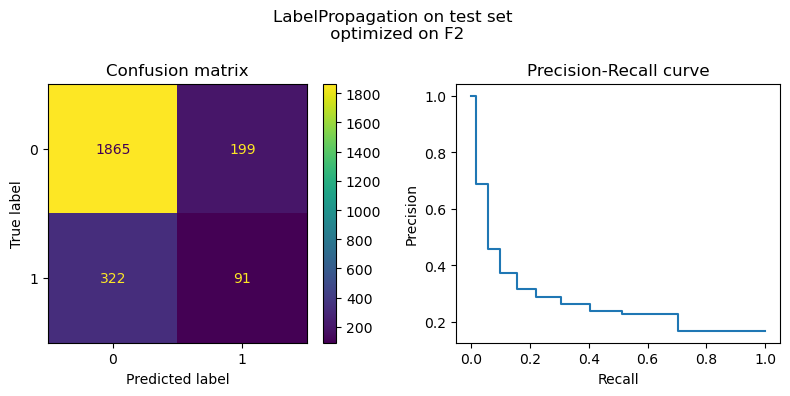

Validation result (optimized on F2): {'model': 'LabelPropagation', 'dataset type': 'test', 'optimized on': 'F2', 'NDCG@200': 0.32221124341667273, 'accuracy': 0.7896649172385951, 'recall': 0.22033898305084745, 'precision': 0.3137931034482759, 'F1': 0.2588904694167852, 'F2': 0.23429454170957775}


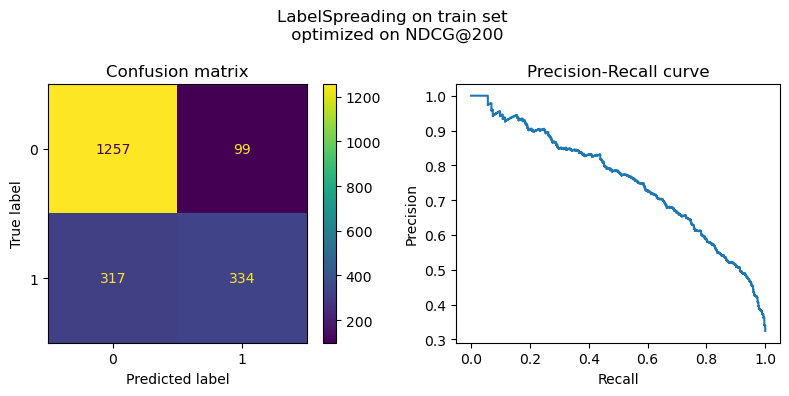

Training result (optimized on NDCG@200): {'model': 'LabelSpreading', 'dataset type': 'train', 'optimized on': 'NDCG@200', 'NDCG@200': 0.7568857314239021, 'accuracy': 0.7927254608868959, 'recall': 0.5130568356374808, 'precision': 0.7713625866050808, 'F1': 0.6162361623616237, 'F2': 0.5498847546921305}


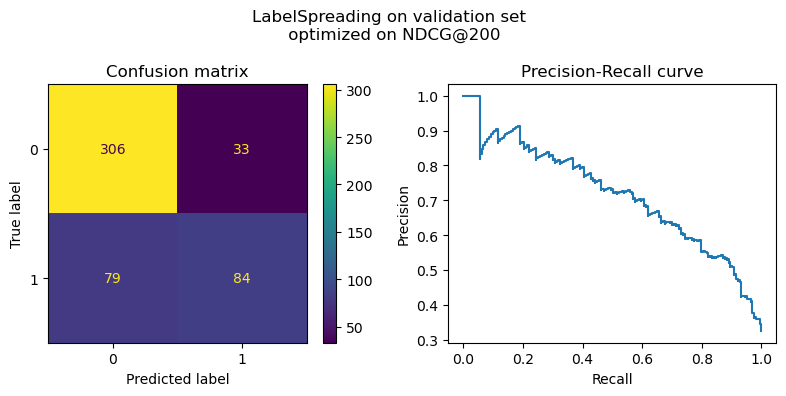

Validation result (optimized on NDCG@200): {'model': 'LabelSpreading', 'dataset type': 'validation', 'optimized on': 'NDCG@200', 'NDCG@200': 0.6297193900367265, 'accuracy': 0.7768924302788844, 'recall': 0.5153374233128835, 'precision': 0.717948717948718, 'F1': 0.6, 'F2': 0.5461638491547465}


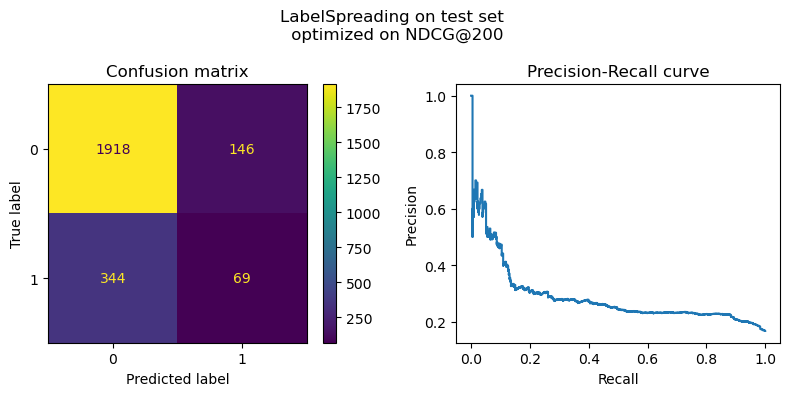

Validation result (optimized on NDCG@200): {'model': 'LabelSpreading', 'dataset type': 'test', 'optimized on': 'NDCG@200', 'NDCG@200': 0.29993537897642153, 'accuracy': 0.8021800565199838, 'recall': 0.16707021791767554, 'precision': 0.3209302325581395, 'F1': 0.21974522292993628, 'F2': 0.1847884306373862}


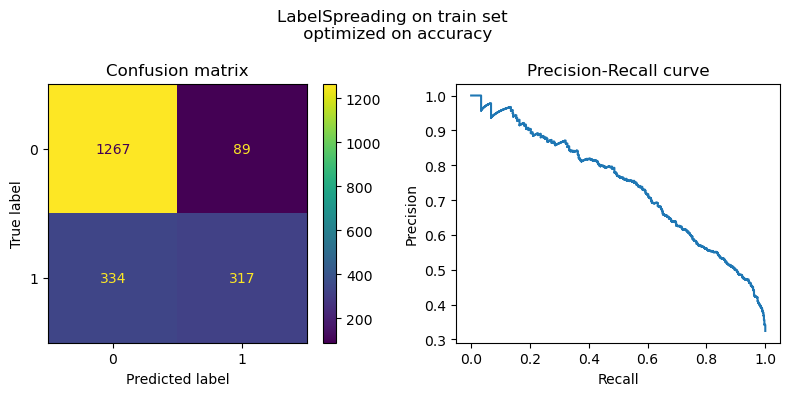

Training result (optimized on accuracy): {'model': 'LabelSpreading', 'dataset type': 'train', 'optimized on': 'accuracy', 'NDCG@200': 0.7544697772661665, 'accuracy': 0.7892376681614349, 'recall': 0.4869431643625192, 'precision': 0.7807881773399015, 'F1': 0.5998107852412488, 'F2': 0.5265780730897011}


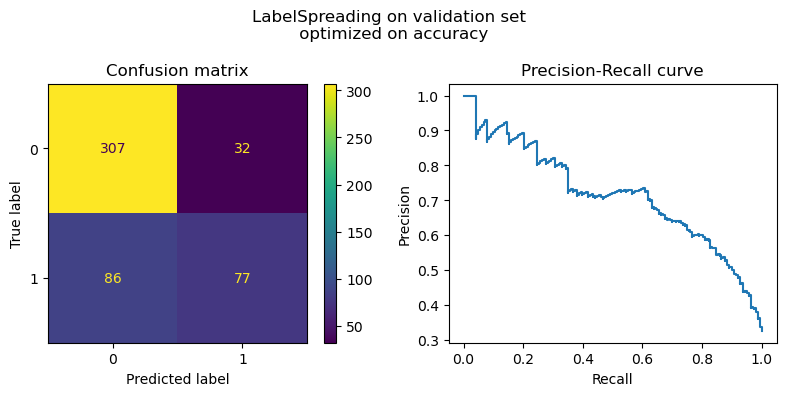

Validation result (optimized on accuracy): {'model': 'LabelSpreading', 'dataset type': 'validation', 'optimized on': 'accuracy', 'NDCG@200': 0.6475539597749135, 'accuracy': 0.7649402390438247, 'recall': 0.4723926380368098, 'precision': 0.7064220183486238, 'F1': 0.5661764705882353, 'F2': 0.5059132720105125}


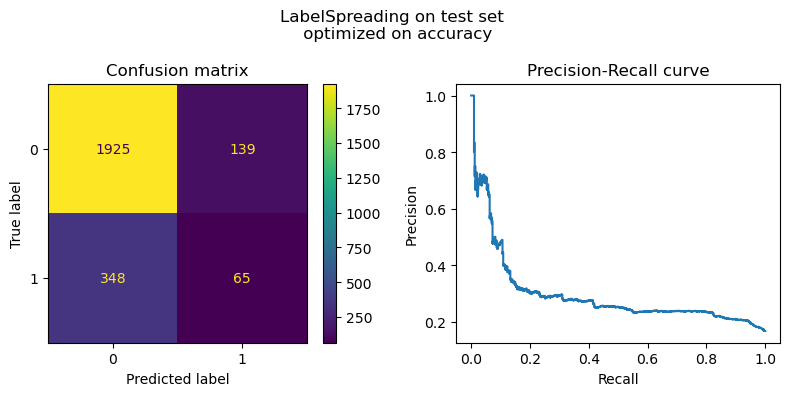

Validation result (optimized on accuracy): {'model': 'LabelSpreading', 'dataset type': 'test', 'optimized on': 'accuracy', 'NDCG@200': 0.3033797362621723, 'accuracy': 0.803391199031086, 'recall': 0.15738498789346247, 'precision': 0.31862745098039214, 'F1': 0.21069692058346842, 'F2': 0.17510775862068967}


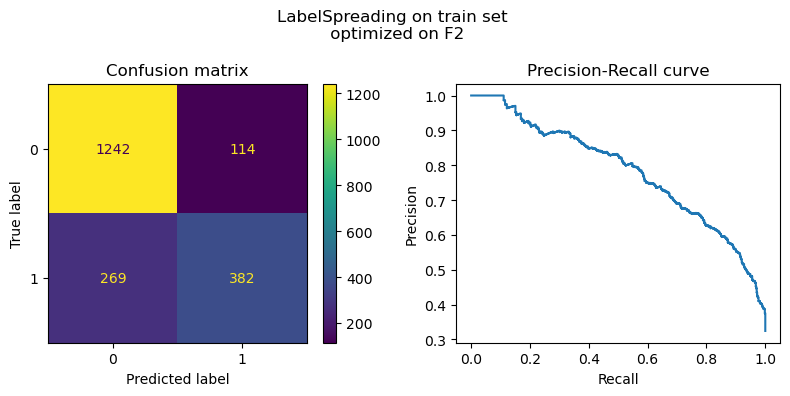

Training result (optimized on F2): {'model': 'LabelSpreading', 'dataset type': 'train', 'optimized on': 'F2', 'NDCG@200': 0.739529245562971, 'accuracy': 0.8091679123069258, 'recall': 0.5867895545314901, 'precision': 0.7701612903225806, 'F1': 0.6660854402789887, 'F2': 0.6161290322580645}


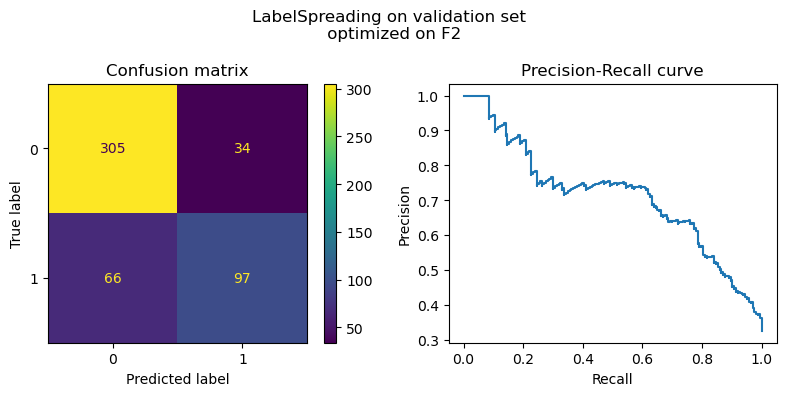

Validation result (optimized on F2): {'model': 'LabelSpreading', 'dataset type': 'validation', 'optimized on': 'F2', 'NDCG@200': 0.6990365032865649, 'accuracy': 0.8007968127490039, 'recall': 0.5950920245398773, 'precision': 0.7404580152671756, 'F1': 0.6598639455782314, 'F2': 0.6194125159642401}


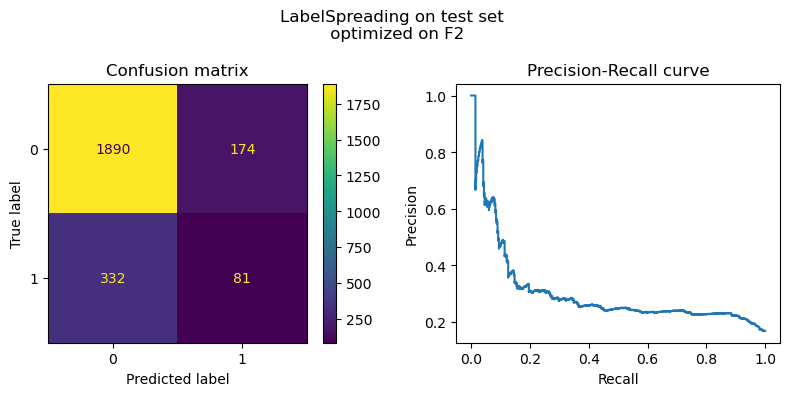

Validation result (optimized on F2): {'model': 'LabelSpreading', 'dataset type': 'test', 'optimized on': 'F2', 'NDCG@200': 0.30274474861633327, 'accuracy': 0.7957206297941057, 'recall': 0.19612590799031476, 'precision': 0.3176470588235294, 'F1': 0.2425149700598802, 'F2': 0.21237545883586784}


In [9]:
# Print report

best_estimator_results = []

for model_name, opt, estimator in best_estimators:
    # Training set
    y_pred_train = estimator.predict(X_train)
    y_pred_train_proba = estimator.predict_proba(X_train)[:, 1] # Get probabilities of the positive label
    result_train = evaluate('train', opt, model_name, estimator, y_train, y_pred_train, y_pred_train_proba, k=K)
    best_estimator_results.append(result_train)
    print(f'Training result (optimized on {opt}): {result_train}')

    # Validation set
    y_pred_val = estimator.predict(X_val)
    y_pred_val_proba = estimator.predict_proba(X_val)[:, 1]
    result_val = evaluate('validation', opt, model_name, estimator, y_val, y_pred_val, y_pred_val_proba, k=K)
    best_estimator_results.append(result_val)
    print(f'Validation result (optimized on {opt}): {result_val}')

    # Test set
    y_pred_test = estimator.predict(X_test)
    y_pred_test_proba = estimator.predict_proba(X_test)[:, 1]
    result_test = evaluate('test', opt, model_name, estimator, y_test, y_pred_test, y_pred_test_proba, k=K)
    best_estimator_results.append(result_test)
    print(f'Validation result (optimized on {opt}): {result_test}')

# Make results into a dataframe
best_estimator_results_df = pd.DataFrame(best_estimator_results)

In [10]:
# Show results
best_estimator_results_df[best_estimator_results_df['dataset type']=='test']

,model,dataset type,optimized on,NDCG@200,accuracy,recall,precision,F1,F2
2,LabelPropagation,test,NDCG@200,0.322331,0.807025,0.154964,0.331606,0.211221,0.173442
5,LabelPropagation,test,accuracy,0.308298,0.798143,0.181598,0.316456,0.230769,0.198518
8,LabelPropagation,test,F2,0.322211,0.789665,0.220339,0.313793,0.258890,0.234295
11,LabelSpreading,test,NDCG@200,0.299935,0.802180,0.167070,0.320930,0.219745,0.184788
14,LabelSpreading,test,accuracy,0.303380,0.803391,0.157385,0.318627,0.210697,0.175108
17,LabelSpreading,test,F2,0.302745,0.795721,0.196126,0.317647,0.242515,0.212375
